Minority (class 0, inner): 120 samples
Majority (class 1, outer): 600 samples
Imbalance ratio (majority / minority): 5.00
Condition majority > 2 * minority: True



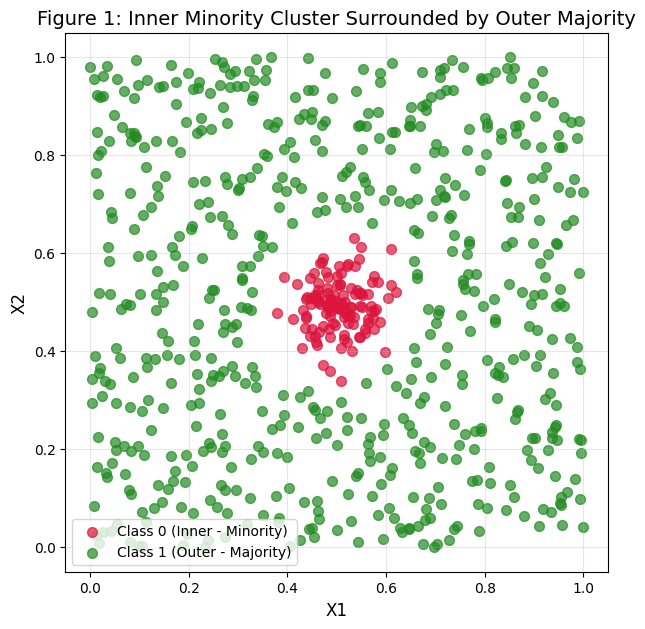

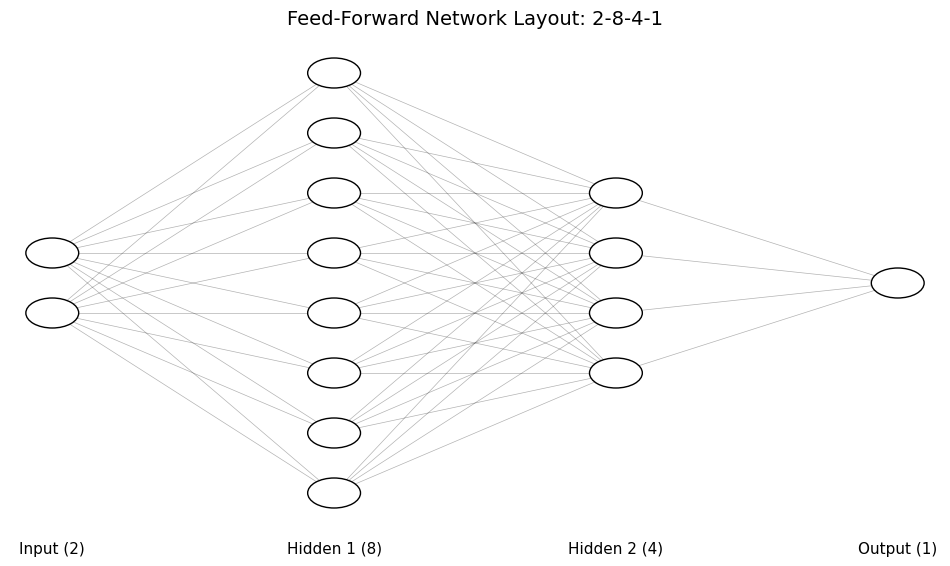


TASK 3: MSE TRACKING EXPERIMENT

Using learning rate = 0.005
Number of independent runs: 5
Epochs per run: 2000

Run 1/5...
Run 2/5...
Run 3/5...
Run 4/5...
Run 5/5...


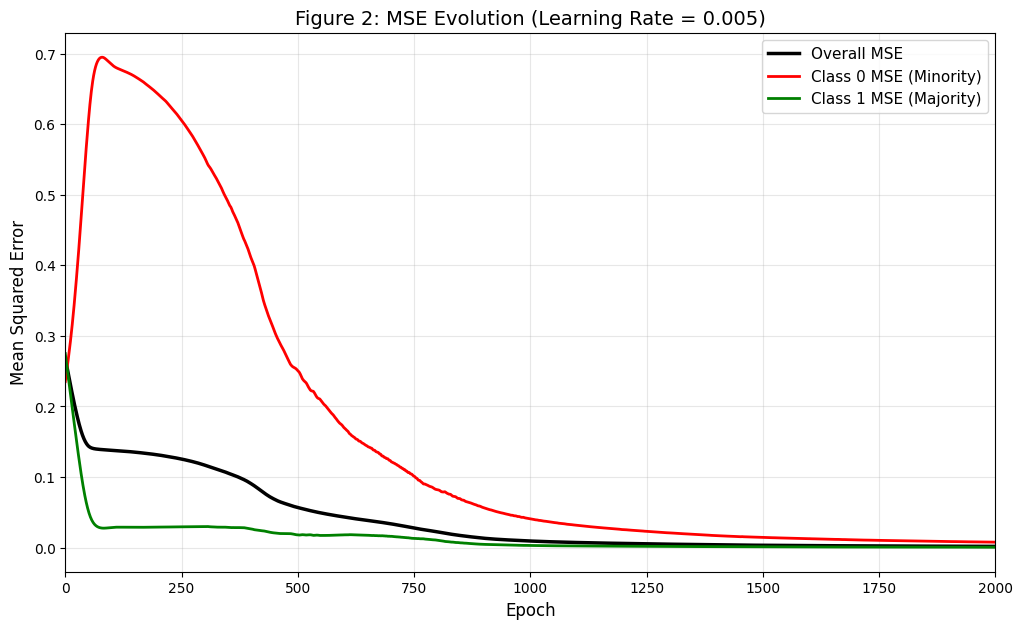


Task 3 completed.
Final Overall MSE: 0.001836
Final Class 0 MSE: 0.007817
Final Class 1 MSE: 0.000640

TASK 4: CONVERGENCE ANALYSIS

Misclassification threshold ε = 0.1
Learning rates considered: [0.001, 0.003, 0.005, 0.007, 0.009, 0.01]
Number of runs per LR: 5


--- Learning rate: 0.001 ---
  Run 1: converged at epoch 1659 | Class 0 MSE: 0.271386 | Class 1 MSE: 0.012227
  Run 2: did NOT reach ε within 2000 epochs
  Run 3: did NOT reach ε within 2000 epochs
  Run 4: did NOT reach ε within 2000 epochs
  Run 5: converged at epoch 1256 | Class 0 MSE: 0.276298 | Class 1 MSE: 0.013327

--- Learning rate: 0.003 ---
  Run 1: did NOT reach ε within 2000 epochs
  Run 2: converged at epoch 1075 | Class 0 MSE: 0.274544 | Class 1 MSE: 0.031648
  Run 3: converged at epoch 631 | Class 0 MSE: 0.290202 | Class 1 MSE: 0.024068
  Run 4: converged at epoch 924 | Class 0 MSE: 0.292510 | Class 1 MSE: 0.021913
  Run 5: converged at epoch 563 | Class 0 MSE: 0.284294 | Class 1 MSE: 0.016774

--- Learning ra

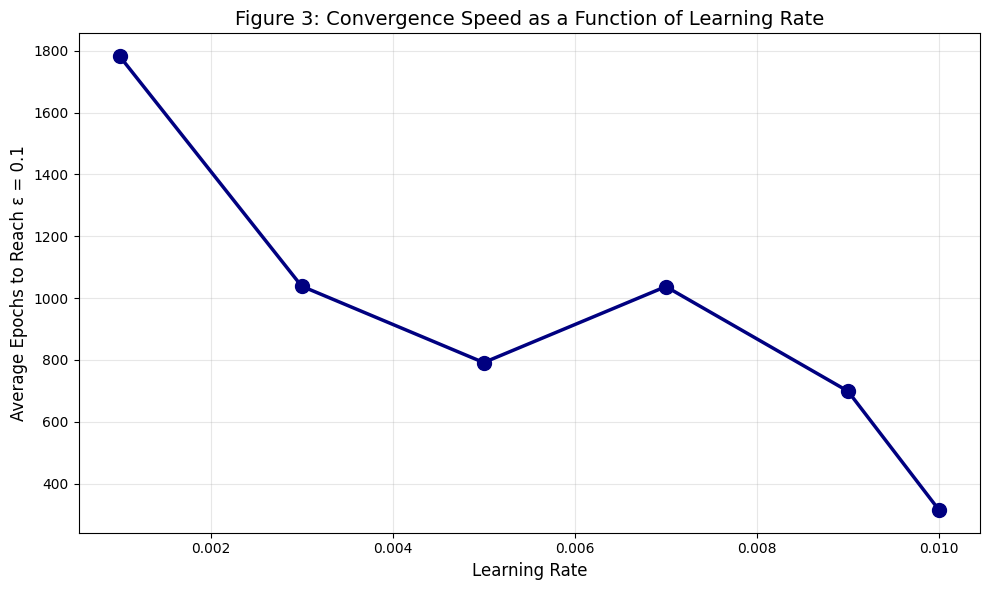


TASK 7: ANALYSIS AND DISCUSSION

1. Fastest convergence:
   Learning rate with minimum avg. iterations: 0.01
   Avg. iterations required: 314.40

2. Impact of class imbalance (MSE ratios):
   LR=0.001: Class 0 / Class 1 MSE = 15.808
   LR=0.003: Class 0 / Class 1 MSE = 14.835
   LR=0.005: Class 0 / Class 1 MSE = 14.683
   LR=0.007: Class 0 / Class 1 MSE = 19.956
   LR=0.009: Class 0 / Class 1 MSE = 14.723
   LR=0.01: Class 0 / Class 1 MSE = 12.074

3. Learning rate selection with balanced criterion:
   LR=0.001: Score=1.4684, Iters=1783.0, MSE_0=0.413954, MSE_1=0.026186
   LR=0.003: Score=1.0488, Iters=1038.6, MSE_0=0.366026, MSE_1=0.024674
   LR=0.005: Score=0.9098, Iters=791.4, MSE_0=0.366982, MSE_1=0.024993
   LR=0.007: Score=1.0567, Iters=1037.2, MSE_0=0.442124, MSE_1=0.022155
   LR=0.009: Score=0.8580, Iters=698.8, MSE_0=0.359712, MSE_1=0.024433
   LR=0.01: Score=0.6349, Iters=314.4, MSE_0=0.258049, MSE_1=0.021372

   Recommended LR (balanced): 0.01
   Justification: good comprom

In [ ]:
# ===============================================================
# Imports
# ===============================================================
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd


# ===============================================================
# Task 1: Data Generation (Minority blob surrounded by Majority ring)
# ===============================================================
np.random.seed(123)

n_minority = 120
n_majority = 600
sigma_center = 0.05
sigma_ring = 0.1  # kept for consistency, though not used explicitly
center_point = np.array([0.5, 0.5])

# Generate minority class (inner cluster)
inner_points = np.random.normal(loc=center_point,
                                scale=sigma_center,
                                size=(n_minority, 2))

# Generate majority class (outer ring)
outer_list = []
while len(outer_list) < n_majority:
    candidate = np.random.rand(2)
    if np.linalg.norm(candidate - center_point) > 0.17:
        outer_list.append(candidate)
outer_points = np.array(outer_list)

# Stack dataset
features_np = np.vstack((inner_points, outer_points))
labels_np = np.array([0] * n_minority + [1] * n_majority)  # 0 = inner, 1 = outer

# Convert to tensors
X_tensor = torch.tensor(features_np, dtype=torch.float32)
y_tensor = torch.tensor(labels_np.reshape(-1, 1), dtype=torch.float32)

# Sanity check on imbalance
print(f"Minority (class 0, inner): {n_minority} samples")
print(f"Majority (class 1, outer): {n_majority} samples")
print(f"Imbalance ratio (majority / minority): {n_majority / n_minority:.2f}")
print(f"Condition majority > 2 * minority: {n_majority > 2 * n_minority}\n")

# Figure 1: Scatter plot of the imbalanced dataset
plt.figure(figsize=(7, 7))
plt.scatter(
    X_tensor[labels_np == 0, 0],
    X_tensor[labels_np == 0, 1],
    s=50,
    alpha=0.7,
    label="Class 0 (Inner - Minority)",
    c="crimson",
)
plt.scatter(
    X_tensor[labels_np == 1, 0],
    X_tensor[labels_np == 1, 1],
    s=50,
    alpha=0.7,
    label="Class 1 (Outer - Majority)",
    c="forestgreen",
)
plt.xlabel("X1", fontsize=12)
plt.ylabel("X2", fontsize=12)
plt.title("Figure 1: Inner Minority Cluster Surrounded by Outer Majority", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# ===============================================================
# Task 2: Feed-Forward Neural Network Architecture
# ===============================================================
"""
Architecture (2-8-4-1):
- 2 input units (coordinates)
- 2 hidden layers with 8 and 4 ReLU units
- 1 output neuron with sigmoid activation for binary classification
"""

class SimpleMLP(nn.Module):
    def __init__(self, in_dim=2, hidden_sizes=(8, 4), out_dim=1):
        super(SimpleMLP, self).__init__()
        self.layer1 = nn.Linear(in_dim, hidden_sizes[0])
        self.layer2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.output_layer = nn.Linear(hidden_sizes[1], out_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = torch.sigmoid(self.output_layer(x))
        return x


def draw_network(ax, layer_sizes=(2, 8, 4, 1),
                 left=0.1, right=0.9, bottom=0.1, top=0.9):
    """Simple fully connected network diagram."""
    v_spacing = (top - bottom) / float(max(layer_sizes))
    h_spacing = (right - left) / float(len(layer_sizes) - 1)

    # Neurons
    for i, layer_size in enumerate(layer_sizes):
        layer_top = top - (top - bottom - v_spacing * (layer_size - 1)) / 2.0
        for j in range(layer_size):
            node = plt.Circle(
                (left + i * h_spacing, layer_top - j * v_spacing),
                v_spacing / 4.0,
                color="white",
                ec="black",
                zorder=4,
            )
            ax.add_artist(node)

    # Connections
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = top - (top - bottom - v_spacing * (n_a - 1)) / 2.0
        layer_top_b = top - (top - bottom - v_spacing * (n_b - 1)) / 2.0
        for j in range(n_a):
            for k in range(n_b):
                ax.plot(
                    [left + i * h_spacing, left + (i + 1) * h_spacing],
                    [layer_top_a - j * v_spacing, layer_top_b - k * v_spacing],
                    "k",
                    lw=0.5,
                    alpha=0.3,
                )

    # Layer labels
    labels = ["Input (2)", "Hidden 1 (8)", "Hidden 2 (4)", "Output (1)"]
    for i, txt in enumerate(labels):
        ax.text(left + i * h_spacing, bottom - 0.05, txt,
                ha="center", fontsize=11)


fig_arch, ax_arch = plt.subplots(figsize=(12, 6))
ax_arch.axis("off")
draw_network(ax_arch, layer_sizes=(2, 8, 4, 1))
plt.title("Feed-Forward Network Layout: 2-8-4-1", fontsize=14, pad=20)
plt.show()


# ===============================================================
# Task 3: Experiment 1 - MSE Tracking (Single Learning Rate)
# ===============================================================
print("\n" + "=" * 60)
print("TASK 3: MSE TRACKING EXPERIMENT")
print("=" * 60)

fixed_lr = 0.005
num_trials = 5
epochs_task3 = 2000

print(f"\nUsing learning rate = {fixed_lr}")
print(f"Number of independent runs: {num_trials}")
print(f"Epochs per run: {epochs_task3}\n")

# To store per-epoch MSE across runs
mse_runs_total = []
mse_runs_class = {0: [], 1: []}

for run_idx in range(num_trials):
    print(f"Run {run_idx + 1}/{num_trials}...")
    net = SimpleMLP(in_dim=2, hidden_sizes=(8, 4), out_dim=1)
    loss_fn = nn.MSELoss(reduction="none")
    opt = optim.Adam(net.parameters(), lr=fixed_lr)

    mse_total_this_run = []
    mse_by_class_this_run = {0: [], 1: []}

    for epoch in range(1, epochs_task3 + 1):
        net.train()
        opt.zero_grad()
        predictions = net(X_tensor)
        per_sample_loss = loss_fn(predictions, y_tensor)
        mean_loss = per_sample_loss.mean()
        mean_loss.backward()
        opt.step()

        # global MSE
        mse_total_this_run.append(mean_loss.item())

        # per-class MSE
        for cls_val in (0, 1):
            mask_cls = (labels_np.reshape(-1) == cls_val)
            if mask_cls.sum() > 0:
                mse_cls = per_sample_loss[mask_cls].mean().item()
            else:
                mse_cls = 0.0
            mse_by_class_this_run[cls_val].append(mse_cls)

    mse_runs_total.append(mse_total_this_run)
    for cls_val in (0, 1):
        mse_runs_class[cls_val].append(mse_by_class_this_run[cls_val])

# Average across runs
avg_mse_over_epochs = [np.mean(vals) for vals in zip(*mse_runs_total)]
avg_mse_class = {
    cls_val: [np.mean(vals) for vals in zip(*mse_runs_class[cls_val])]
    for cls_val in (0, 1)
}

# Figure 2: MSE trajectories
plt.figure(figsize=(12, 7))
plt.plot(avg_mse_over_epochs, label="Overall MSE", linewidth=2.5, color="black")
plt.plot(avg_mse_class[0], label="Class 0 MSE (Minority)", linewidth=2, color="red")
plt.plot(avg_mse_class[1], label="Class 1 MSE (Majority)", linewidth=2, color="green")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Mean Squared Error", fontsize=12)
plt.title(f"Figure 2: MSE Evolution (Learning Rate = {fixed_lr})", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(0, epochs_task3)
plt.show()

print("\nTask 3 completed.")
print(f"Final Overall MSE: {avg_mse_over_epochs[-1]:.6f}")
print(f"Final Class 0 MSE: {avg_mse_class[0][-1]:.6f}")
print(f"Final Class 1 MSE: {avg_mse_class[1][-1]:.6f}")


# ===============================================================
# Task 4: Experiment 2 - Convergence Analysis
# ===============================================================
print("\n" + "=" * 60)
print("TASK 4: CONVERGENCE ANALYSIS")
print("=" * 60)

epsilon = 0.1  # target misclassification rate
candidate_lrs = [0.001, 0.003, 0.005, 0.007, 0.009, 0.01]
trials_per_lr = 5
max_epochs = 2000

lr_vs_iterations = []
summary_records = []

print(f"\nMisclassification threshold ε = {epsilon}")
print(f"Learning rates considered: {candidate_lrs}")
print(f"Number of runs per LR: {trials_per_lr}\n")

for eta in candidate_lrs:
    print(f"\n--- Learning rate: {eta} ---")
    iters_for_this_lr = []
    mse_at_stop = {0: [], 1: []}

    for run_idx in range(trials_per_lr):
        model_lr = SimpleMLP(in_dim=2, hidden_sizes=(8, 4), out_dim=1)
        loss_fn_lr = nn.MSELoss(reduction="none")
        optimizer_lr = optim.Adam(model_lr.parameters(), lr=eta)

        converged_flag = False

        for epoch in range(1, max_epochs + 1):
            model_lr.train()
            optimizer_lr.zero_grad()
            out = model_lr(X_tensor)
            loss_per_sample = loss_fn_lr(out, y_tensor)
            mean_epoch_loss = loss_per_sample.mean()
            mean_epoch_loss.backward()
            optimizer_lr.step()

            # misclassification check
            binary_preds = (out >= 0.5).float()
            mis_rate = (binary_preds != y_tensor).float().mean().item()

            if mis_rate <= epsilon:
                # per-class MSE at convergence
                mse_inner = loss_per_sample[labels_np == 0].mean().item()
                mse_outer = loss_per_sample[labels_np == 1].mean().item()

                print(
                    f"  Run {run_idx + 1}: converged at epoch {epoch} | "
                    f"Class 0 MSE: {mse_inner:.6f} | Class 1 MSE: {mse_outer:.6f}"
                )

                iters_for_this_lr.append(epoch)
                mse_at_stop[0].append(mse_inner)
                mse_at_stop[1].append(mse_outer)
                converged_flag = True
                break

        if not converged_flag:
            print(f"  Run {run_idx + 1}: did NOT reach ε within {max_epochs} epochs")
            iters_for_this_lr.append(max_epochs)
            with torch.no_grad():
                final_out = model_lr(X_tensor)
                final_loss = loss_fn_lr(final_out, y_tensor)
                mse_inner = final_loss[labels_np == 0].mean().item()
                mse_outer = final_loss[labels_np == 1].mean().item()
                mse_at_stop[0].append(mse_inner)
                mse_at_stop[1].append(mse_outer)

    # Average stats for this LR
    avg_iter_lr = sum(iters_for_this_lr) / len(iters_for_this_lr)
    avg_mse_inner = sum(mse_at_stop[0]) / len(mse_at_stop[0])
    avg_mse_outer = sum(mse_at_stop[1]) / len(mse_at_stop[1])

    lr_vs_iterations.append((eta, avg_iter_lr))
    overall_mse = (avg_mse_inner * n_minority + avg_mse_outer * n_majority) / (
        n_minority + n_majority
    )

    summary_records.append(
        {
            "Learning Rate": eta,
            "Avg Iterations": avg_iter_lr,
            "Class 0 MSE": avg_mse_inner,
            "Class 1 MSE": avg_mse_outer,
            "Total MSE": overall_mse,
        }
    )

# Table 1: Convergence summary
print("\n" + "=" * 60)
print("TABLE 1: CONVERGENCE SUMMARY")
print("=" * 60)
df_summary = pd.DataFrame(summary_records)
print(df_summary.to_string(index=False))
print()

# Figure 3: Iterations vs LR
lr_values = [pair[0] for pair in lr_vs_iterations]
avg_iters_values = [pair[1] for pair in lr_vs_iterations]

plt.figure(figsize=(10, 6))
plt.plot(lr_values, avg_iters_values, marker="o", markersize=10,
         linewidth=2.5, c="navy")
plt.xlabel("Learning Rate", fontsize=12)
plt.ylabel(f"Average Epochs to Reach ε = {epsilon}", fontsize=12)
plt.title("Figure 3: Convergence Speed as a Function of Learning Rate", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ===============================================================
# Task 7: Analysis and Discussion (Programmatic Part)
# ===============================================================
print("\n" + "=" * 60)
print("TASK 7: ANALYSIS AND DISCUSSION")
print("=" * 60)

# 1. Learning rate with fastest convergence
idx_fastest = avg_iters_values.index(min(avg_iters_values))
best_lr_fast = lr_values[idx_fastest]
print("\n1. Fastest convergence:")
print(f"   Learning rate with minimum avg. iterations: {best_lr_fast}")
print(f"   Avg. iterations required: {avg_iters_values[idx_fastest]:.2f}")

# 2. Imbalance: compare per-class MSE
print("\n2. Impact of class imbalance (MSE ratios):")
for rec in summary_records:
    lr_val = rec["Learning Rate"]
    m0 = rec["Class 0 MSE"]
    m1 = rec["Class 1 MSE"]
    ratio_m0_m1 = m0 / m1 if m1 > 0 else float("inf")
    print(f"   LR={lr_val}: Class 0 / Class 1 MSE = {ratio_m0_m1:.3f}")

# 3. Balanced criterion: combine speed + per-class balance
print("\n3. Learning rate selection with balanced criterion:")

balanced_scores = []
max_iter_global = max(avg_iters_values)

for rec in summary_records:
    lr_val = rec["Learning Rate"]
    it_val = rec["Avg Iterations"]
    m0 = rec["Class 0 MSE"]
    m1 = rec["Class 1 MSE"]

    # Normalize iterations
    norm_iter = it_val / max_iter_global
    # Relative imbalance
    if max(m0, m1) > 0:
        imbalance = abs(m0 - m1) / max(m0, m1)
    else:
        imbalance = 0.0

    combined_score = norm_iter + 0.5 * imbalance
    balanced_scores.append((lr_val, combined_score, it_val, m0, m1))

    print(
        f"   LR={lr_val}: Score={combined_score:.4f}, "
        f"Iters={it_val:.1f}, MSE_0={m0:.6f}, MSE_1={m1:.6f}"
    )

best_balanced = min(balanced_scores, key=lambda x: x[1])
print(f"\n   Recommended LR (balanced): {best_balanced[0]}")
print("   Justification: good compromise between speed and class-wise MSE.")

# 4. Class-specific preferences
print("\n4. Class-specific recommendations:")
best_for_minority = min(summary_records, key=lambda r: r["Class 0 MSE"])
best_for_majority = min(summary_records, key=lambda r: r["Class 1 MSE"])

print(
    f"   Best for Class 0 (Minority): LR={best_for_minority['Learning Rate']}, "
    f"MSE_0={best_for_minority['Class 0 MSE']:.6f}"
)
print(
    f"   Best for Class 1 (Majority): LR={best_for_majority['Learning Rate']}, "
    f"MSE_1={best_for_majority['Class 1 MSE']:.6f}"
)

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)


Minority class (inner):  120
Majority class (outer):  600
Ratio (majority/minority): 5.00



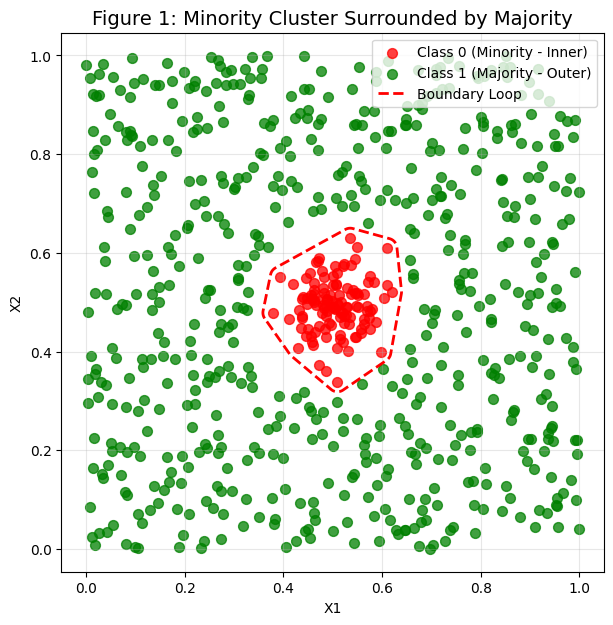

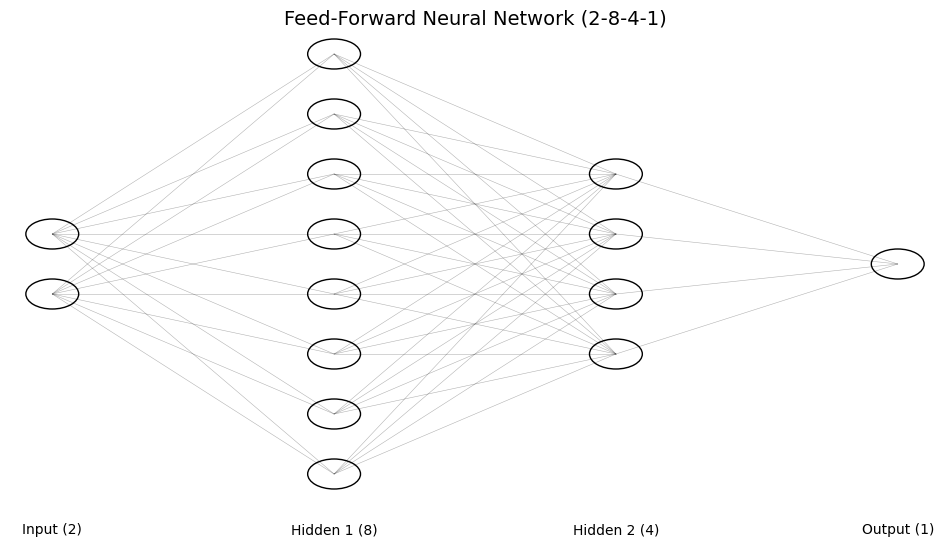


TASK 3: MSE TRACKING
Run 1/5...
Run 2/5...
Run 3/5...
Run 4/5...
Run 5/5...


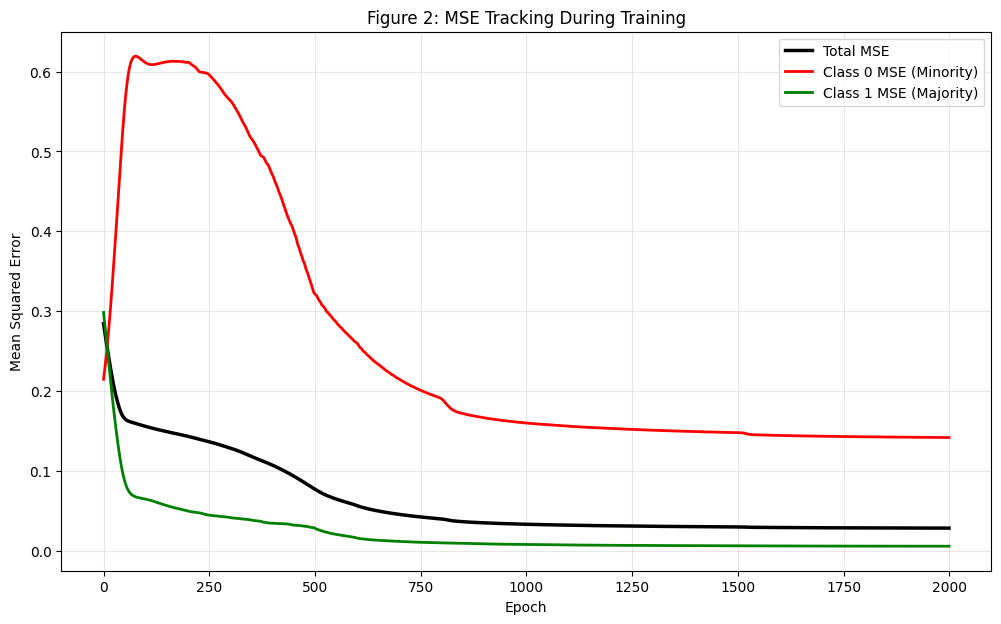


TASK 4: CONVERGENCE ANALYSIS

Testing LR = 0.001...
  Run 1: Did NOT converge
  Run 2: Did NOT converge
  Run 3: Converged at epoch 1458 | C0=0.307528, C1=0.025010
  Run 4: Converged at epoch 1481 | C0=0.261694, C1=0.088984
  Run 5: Did NOT converge

Testing LR = 0.003...
  Run 1: Converged at epoch 1098 | C0=0.276590, C1=0.026239
  Run 2: Converged at epoch 507 | C0=0.271309, C1=0.009073
  Run 3: Did NOT converge
  Run 4: Converged at epoch 593 | C0=0.277388, C1=0.022285
  Run 5: Converged at epoch 901 | C0=0.290535, C1=0.020688

Testing LR = 0.005...
  Run 1: Converged at epoch 373 | C0=0.280119, C1=0.016685
  Run 2: Converged at epoch 560 | C0=0.290588, C1=0.017700
  Run 3: Converged at epoch 411 | C0=0.272291, C1=0.016041
  Run 4: Did NOT converge
  Run 5: Converged at epoch 400 | C0=0.272182, C1=0.010641

Testing LR = 0.007...
  Run 1: Converged at epoch 419 | C0=0.270504, C1=0.012122
  Run 2: Converged at epoch 259 | C0=0.270044, C1=0.009594
  Run 3: Converged at epoch 249 | C0=

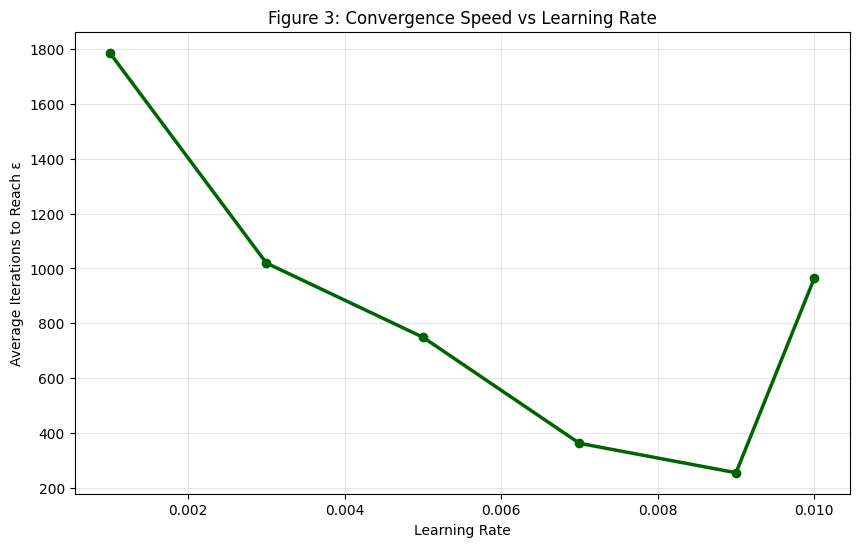


TASK 7: SUMMARY & ANALYSIS

Fastest LR: 0.009 (avg iterations = 254.00)

Class Imbalance Effects:
  LR=0.001: ratio=9.6081
  LR=0.003: ratio=17.0594
  LR=0.005: ratio=20.3682
  LR=0.007: ratio=19.6660
  LR=0.009: ratio=17.3385
  LR=0.01: ratio=20.3837

Balanced Optimal LR: 0.009

Best for Class 0: LR=0.007
Best for Class 1: LR=0.007

ANALYSIS COMPLETE


In [ ]:
# ===============================================================
# Setup & Imports
# ===============================================================
!pip install alphashape

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

from alphashape import alphashape
from shapely.geometry import MultiPoint


# ===============================================================
# Task 1: Data Generation (Inner minority surrounded by outer majority)
# ===============================================================
np.random.seed(123)

n_minority = 120   # inner class size
n_majority = 600   # outer class size
sigma_inner = 0.05
center_point = np.array([0.5, 0.5])

# Inner minority cluster (class 0)
inner_cloud = np.random.normal(
    loc=center_point,
    scale=sigma_inner,
    size=(n_minority, 2)
)

# Outer majority ring (class 1)
outer_list = []
while len(outer_list) < n_majority:
    cand = np.random.rand(2)
    if np.linalg.norm(cand - center_point) > 0.17:
        outer_list.append(cand)
outer_ring = np.array(outer_list)

# Combine
features_np = np.vstack((inner_cloud, outer_ring))
labels_np = np.array([0]*n_minority + [1]*n_majority)

# Convert to tensors
X_tensor = torch.tensor(features_np, dtype=torch.float32)
y_tensor = torch.tensor(labels_np.reshape(-1,1), dtype=torch.float32)

print(f"Minority class (inner):  {n_minority}")
print(f"Majority class (outer):  {n_majority}")
print(f"Ratio (majority/minority): {n_majority/n_minority:.2f}\n")


# ===============================================================
# Figure 1: Red inner cluster, Green outer cluster, Red dashed boundary
# ===============================================================
plt.figure(figsize=(7,7))

# Inner = RED
plt.scatter(
    X_tensor[labels_np == 0, 0],
    X_tensor[labels_np == 0, 1],
    c="red",
    s=50,
    alpha=0.75,
    label="Class 0 (Minority - Inner)"
)

# Outer = GREEN
plt.scatter(
    X_tensor[labels_np == 1, 0],
    X_tensor[labels_np == 1, 1],
    c="green",
    s=50,
    alpha=0.75,
    label="Class 1 (Majority - Outer)"
)

# Alpha-shape boundary around inner cluster
alpha_val = 0.3
a_shape = alphashape(inner_cloud, alpha_val)

# Buffered boundary (RED dashed)
buffer_dist = 0.02
buf_boundary = a_shape.buffer(buffer_dist)

bx, by = buf_boundary.exterior.xy
plt.plot(bx, by, color="red", linestyle="--", linewidth=2, label="Boundary Loop")

plt.title("Figure 1: Minority Cluster Surrounded by Majority", fontsize=14)
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True, alpha=0.3)
plt.legend()
plt.axis("equal")
plt.show()


# ===============================================================
# Task 2: Feed-Forward Neural Network (2-8-4-1)
# ===============================================================
class SimpleMLP(nn.Module):
    def __init__(self, in_dim=2, h=(8,4), out_dim=1):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, h[0])
        self.fc2 = nn.Linear(h[0], h[1])
        self.out = nn.Linear(h[1], out_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.out(x))


# Network diagram
def draw_net(ax, layers=(2,8,4,1), left=0.1, right=0.9, bottom=0.1, top=0.9):
    spacing_h = (right - left) / (len(layers) - 1)
    spacing_v = (top - bottom) / max(layers)

    for i, layer_size in enumerate(layers):
        top_y = top - (top-bottom-spacing_v*(layer_size-1))/2
        for j in range(layer_size):
            circ = plt.Circle(
                (left + i*spacing_h, top_y - j*spacing_v),
                spacing_v/4, color="white", ec="black"
            )
            ax.add_artist(circ)

    for i, (a, b) in enumerate(zip(layers[:-1], layers[1:])):
        top_a = top - (top-bottom-spacing_v*(a-1))/2
        top_b = top - (top-bottom-spacing_v*(b-1))/2
        for j in range(a):
            for k in range(b):
                ax.plot(
                    [left+i*spacing_h, left+(i+1)*spacing_h],
                    [top_a - j*spacing_v, top_b - k*spacing_v],
                    "k", lw=0.4, alpha=0.3
                )

    labels = ["Input (2)", "Hidden 1 (8)", "Hidden 2 (4)", "Output (1)"]
    for i, text in enumerate(labels):
        ax.text(left+i*spacing_h, bottom-0.05, text, ha="center")

fig, ax = plt.subplots(figsize=(12,6))
ax.axis("off")
draw_net(ax)
plt.title("Feed-Forward Neural Network (2-8-4-1)", fontsize=14)
plt.show()


# ===============================================================
# Task 3: MSE Tracking (Learning Rate = 0.005)
# ===============================================================
print("\n" + "="*60)
print("TASK 3: MSE TRACKING")
print("="*60)

lr_task3 = 0.005
runs = 5
epochs = 2000

all_total_mse = []
all_cls_mse = {0:[], 1:[]}

for r in range(runs):
    print(f"Run {r+1}/{runs}...")
    model = SimpleMLP()
    optimizer = optim.Adam(model.parameters(), lr=lr_task3)
    criterion = nn.MSELoss(reduction="none")

    total_list = []
    cls_list = {0:[], 1:[]}

    for ep in range(1, epochs+1):
        optimizer.zero_grad()
        out = model(X_tensor)
        loss_each = criterion(out, y_tensor)
        loss = loss_each.mean()
        loss.backward()
        optimizer.step()

        total_list.append(loss.item())

        for c in (0,1):
            m = (labels_np == c)
            cls_list[c].append(loss_each[m].mean().item())

    all_total_mse.append(total_list)
    all_cls_mse[0].append(cls_list[0])
    all_cls_mse[1].append(cls_list[1])

avg_total = [np.mean(v) for v in zip(*all_total_mse)]
avg_cls = {
    0: [np.mean(v) for v in zip(*all_cls_mse[0])],
    1: [np.mean(v) for v in zip(*all_cls_mse[1])]
}

# MSE Curves (keep red/green)
plt.figure(figsize=(12,7))
plt.plot(avg_total, color="black", linewidth=2.5, label="Total MSE")
plt.plot(avg_cls[0], color="red", linewidth=2, label="Class 0 MSE (Minority)")
plt.plot(avg_cls[1], color="green", linewidth=2, label="Class 1 MSE (Majority)")
plt.grid(alpha=0.3)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Figure 2: MSE Tracking During Training")
plt.legend()
plt.show()


# ===============================================================
# Task 4: Convergence Analysis
# ===============================================================
print("\n" + "="*60)
print("TASK 4: CONVERGENCE ANALYSIS")
print("="*60)

eps = 0.1
LRs = [0.001,0.003,0.005,0.007,0.009,0.01]
runs_lr = 5
epochs_lr = 2000

convergence_info = []
iter_plot = []

for lr in LRs:
    print(f"\nTesting LR = {lr}...")
    iter_list = []
    mse_store = {0:[], 1:[]}

    for r in range(runs_lr):
        model = SimpleMLP()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss(reduction="none")

        converged = False

        for ep in range(1, epochs_lr+1):
            optimizer.zero_grad()
            out = model(X_tensor)
            loss_each = criterion(out, y_tensor)
            loss_mean = loss_each.mean()
            loss_mean.backward()
            optimizer.step()

            preds = (out >= 0.5).float()
            miss = (preds != y_tensor).float().mean().item()

            if miss <= eps:
                mse_0 = loss_each[labels_np==0].mean().item()
                mse_1 = loss_each[labels_np==1].mean().item()

                print(f"  Run {r+1}: Converged at epoch {ep} | C0={mse_0:.6f}, C1={mse_1:.6f}")
                iter_list.append(ep)
                mse_store[0].append(mse_0)
                mse_store[1].append(mse_1)
                converged = True
                break

        if not converged:
            print(f"  Run {r+1}: Did NOT converge")
            iter_list.append(epochs_lr)
            with torch.no_grad():
                out = model(X_tensor)
                loss_each = criterion(out, y_tensor)
                mse_store[0].append(loss_each[labels_np==0].mean().item())
                mse_store[1].append(loss_each[labels_np==1].mean().item())

    avg_iters = np.mean(iter_list)
    avg_m0 = np.mean(mse_store[0])
    avg_m1 = np.mean(mse_store[1])

    iter_plot.append((lr, avg_iters))
    total_mse = (avg_m0*n_minority + avg_m1*n_majority)/(n_minority+n_majority)

    convergence_info.append({
        "Learning Rate": lr,
        "Avg Iterations": avg_iters,
        "Class 0 MSE": avg_m0,
        "Class 1 MSE": avg_m1,
        "Total MSE": total_mse
    })

# Print Table
print("\nCONVERGENCE RESULTS")
df_table = pd.DataFrame(convergence_info)
print(df_table.to_string(index=False))


# Plot LR vs Iterations
lr_vals = [t[0] for t in iter_plot]
iter_vals = [t[1] for t in iter_plot]

plt.figure(figsize=(10,6))
plt.plot(lr_vals, iter_vals, marker="o", color="darkgreen", linewidth=2.5)
plt.xlabel("Learning Rate")
plt.ylabel("Average Iterations to Reach ε")
plt.title("Figure 3: Convergence Speed vs Learning Rate")
plt.grid(alpha=0.3)
plt.show()


# ===============================================================
# Task 7: Summary Output
# ===============================================================
print("\n" + "="*60)
print("TASK 7: SUMMARY & ANALYSIS")
print("="*60)

# Fastest LR
idx_fast = np.argmin(iter_vals)
best_lr = lr_vals[idx_fast]
print(f"\nFastest LR: {best_lr} (avg iterations = {iter_vals[idx_fast]:.2f})")

# Class-imbalance effects
print("\nClass Imbalance Effects:")
for row in convergence_info:
    ratio = row["Class 0 MSE"] / row["Class 1 MSE"]
    print(f"  LR={row['Learning Rate']}: ratio={ratio:.4f}")

# Balanced LR
scores = []
max_iter = max(iter_vals)

for row in convergence_info:
    it = row["Avg Iterations"]
    m0 = row["Class 0 MSE"]
    m1 = row["Class 1 MSE"]
    norm = it/max_iter
    imb = abs(m0-m1)/max(m0,m1)
    score = norm + 0.5*imb
    scores.append((row["Learning Rate"], score))

best_balanced = sorted(scores, key=lambda x: x[1])[0][0]
print(f"\nBalanced Optimal LR: {best_balanced}")

# Per-class best
best_c0 = min(convergence_info, key=lambda x:x["Class 0 MSE"])
best_c1 = min(convergence_info, key=lambda x:x["Class 1 MSE"])

print(f"\nBest for Class 0: LR={best_c0['Learning Rate']}")
print(f"Best for Class 1: LR={best_c1['Learning Rate']}")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
